## NYC taxi trip duration prediction

As per DataTalksClub's ML Ops zoomcamp, the ML experiments for trip duration prediction from the NYC taxi data using xgboost model were tracked. 

References: 
- [DTC ML Ops zoomcamp 2024 module 2](https://github.com/DataTalksClub/mlops-zoomcamp/tree/main/02-experiment-tracking)
- [NYC Taxi Dataset](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

Import Libraries

In [1]:
!python --version

Python 3.9.19


In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [3]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1721811618075, experiment_id='1', last_update_time=1721811618075, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [ ]:
!wget -P ~/data https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet
!wget -P ~/data https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet

In [ ]:
!wget -P ~/data https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-03.parquet

In [8]:
jan_2023 = pd.read_parquet('~/data/yellow_tripdata_2023-01.parquet')
# jan_2023 = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

In [9]:
jan_2023.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [10]:
jan_2023.shape

(3066766, 19)

In [11]:
jan_2023.nunique()

VendorID                       2
tpep_pickup_datetime     1610975
tpep_dropoff_datetime    1611319
passenger_count               10
trip_distance               4387
RatecodeID                     7
store_and_fwd_flag             2
PULocationID                 257
DOLocationID                 261
payment_type                   5
fare_amount                 6873
extra                         68
mta_tax                       10
tip_amount                  4036
tolls_amount                 776
improvement_surcharge          5
total_amount               15871
congestion_surcharge           3
airport_fee                    3
dtype: int64

In [12]:
jan_2023.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

In [13]:
jan_2023['duration'] = (jan_2023['tpep_dropoff_datetime'] - jan_2023['tpep_pickup_datetime']) / pd.Timedelta(minutes=1)

In [14]:
jan_2023['duration'].describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64

In [15]:
filtered_jan_2023 = jan_2023[(jan_2023['duration'] >= 1) & (jan_2023['duration'] <= 60)]

In [16]:
# percentage of filtered data 
filtered_jan_2023.shape[0] / jan_2023.shape[0] * 100

98.1220282212598

In [17]:
filtered_jan_2023.nunique()

VendorID                       2
tpep_pickup_datetime     1596945
tpep_dropoff_datetime    1597754
passenger_count                9
trip_distance               3759
RatecodeID                     6
store_and_fwd_flag             2
PULocationID                 255
DOLocationID                 260
payment_type                   5
fare_amount                 6148
extra                         64
mta_tax                       10
tip_amount                  3671
tolls_amount                 694
improvement_surcharge          5
total_amount               14512
congestion_surcharge           3
airport_fee                    3
duration                    3541
dtype: int64

In [ ]:
categorical = ['PULocationID', 'DOLocationID']
filtered_jan_2023[categorical] = filtered_jan_2023[categorical].astype(str)

In [19]:
dict_feats = filtered_jan_2023[categorical].to_dict(orient='records')

In [20]:
dv = DictVectorizer()
X_train = dv.fit_transform(dict_feats)

In [21]:
X_train.shape

(3009173, 515)

In [4]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
    
    # add trip duration in minutes as a col
    df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime) / pd.Timedelta(minutes=1)
    # only include the data with duration btw 1 and 60 min (inclusive)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    # Location ID cols as str
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [5]:
df_train = read_dataframe('~/data/yellow_tripdata_2023-01.parquet')
df_val= read_dataframe('~/data/yellow_tripdata_2023-02.parquet')

In [6]:
len(df_train), len(df_val)

(3009173, 2855951)

In [7]:
categorical = ['PULocationID', 'DOLocationID']

dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [8]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.6492610279057605

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


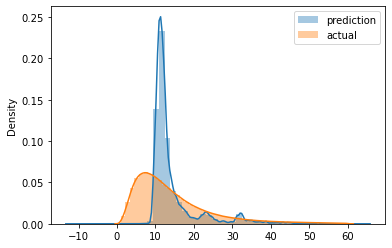

In [12]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.81183265470218

In [22]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [10]:
with mlflow.start_run():

    mlflow.set_tag("developer", "amy")

    mlflow.log_param("train-data-path", "../data/yellow_tripdata_2023-01.parquet")
    mlflow.log_param("valid-data-path", "../data/yellow_tripdata_2023-02.parquet")

    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_artifact(local_path="../models/lin_reg.bin", artifact_path="models_pickle")
 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [9]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [10]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [11]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(valid, 'validation')],
            early_stopping_rounds=10
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [12]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # exp(-3)=0.05 exp(0)=1
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:squarederror',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials()
)

  0%|                                                                   | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:02:07] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.62180                                                                                    
[1]	validation-rmse:9.27097                                                                                    
[2]	validation-rmse:8.99639                                                                                    
[3]	validation-rmse:8.78242                                                                                    
[4]	validation-rmse:8.61202                                                                                    
[5]	validation-rmse:8.48093                                                                                    
[6]	validation-rmse:8.37802                                                                                    
[7]	validation-rmse:8.29629                                                                                    
[8]	validation-rmse:8.23049                                                                             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:03:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.47281                                                                                    
[1]	validation-rmse:8.94930                                                                                    
[2]	validation-rmse:8.53692                                                                                    
[3]	validation-rmse:8.19422                                                                                    
[4]	validation-rmse:7.74789                                                                                    
[5]	validation-rmse:7.36469                                                                                    
[6]	validation-rmse:7.17818                                                                                    
[7]	validation-rmse:6.84898                                                                                    
[8]	validation-rmse:6.58068                                                                             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:09:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.66098                                                                                    
[1]	validation-rmse:9.29708                                                                                    
[2]	validation-rmse:8.97804                                                                                    
[3]	validation-rmse:8.69961                                                                                    
[4]	validation-rmse:8.37549                                                                                    
[5]	validation-rmse:8.15827                                                                                    
[6]	validation-rmse:7.85956                                                                                    
[7]	validation-rmse:7.66932                                                                                    
[8]	validation-rmse:7.52274                                                                             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:15:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.55001                                                                                    
[1]	validation-rmse:9.09502                                                                                    
[2]	validation-rmse:8.71402                                                                                    
[3]	validation-rmse:8.39627                                                                                    
[4]	validation-rmse:7.98933                                                                                    
[5]	validation-rmse:7.75232                                                                                    
[6]	validation-rmse:7.42655                                                                                    
[7]	validation-rmse:7.10911                                                                                    
[8]	validation-rmse:6.84420                                                                             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:21:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.81415                                                                                    
[1]	validation-rmse:8.09513                                                                                    
[2]	validation-rmse:7.66277                                                                                    
[3]	validation-rmse:7.43361                                                                                    
[4]	validation-rmse:6.94417                                                                                    
[5]	validation-rmse:6.82564                                                                                    
[6]	validation-rmse:6.76394                                                                                    
[7]	validation-rmse:6.49287                                                                                    
[8]	validation-rmse:6.45767                                                                             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:23:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.36721                                                                                    
[1]	validation-rmse:8.86033                                                                                    
[2]	validation-rmse:8.45599                                                                                    
[3]	validation-rmse:8.16652                                                                                    
[4]	validation-rmse:7.94263                                                                                    
[5]	validation-rmse:7.78955                                                                                    
[6]	validation-rmse:7.55622                                                                                    
[7]	validation-rmse:7.46858                                                                                    
[8]	validation-rmse:7.39442                                                                             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:26:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.80435                                                                                    
[1]	validation-rmse:9.56417                                                                                    
[2]	validation-rmse:9.34519                                                                                    
[3]	validation-rmse:9.14384                                                                                    
[4]	validation-rmse:8.96115                                                                                    
[5]	validation-rmse:8.79699                                                                                    
[6]	validation-rmse:8.59912                                                                                    
[7]	validation-rmse:8.45818                                                                                    
[8]	validation-rmse:8.27317                                                                             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:29:31] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.88046                                                                                    
[1]	validation-rmse:7.35247                                                                                    
[2]	validation-rmse:6.72350                                                                                    
[3]	validation-rmse:6.62325                                                                                    
[4]	validation-rmse:6.40145                                                                                    
[5]	validation-rmse:6.34834                                                                                    
[6]	validation-rmse:6.20442                                                                                    
[7]	validation-rmse:6.09212                                                                                    
[8]	validation-rmse:6.05185                                                                             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:32:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.55668                                                                                    
[1]	validation-rmse:9.12199                                                                                    
[2]	validation-rmse:8.74990                                                                                    
[3]	validation-rmse:8.43476                                                                                    
[4]	validation-rmse:8.16780                                                                                    
[5]	validation-rmse:7.78752                                                                                    
[6]	validation-rmse:7.45662                                                                                    
[7]	validation-rmse:7.28193                                                                                    
[8]	validation-rmse:6.98707                                                                             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:38:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.11598                                                                                    
[1]	validation-rmse:8.55371                                                                                    
[2]	validation-rmse:8.21264                                                                                    
[3]	validation-rmse:7.96200                                                                                    
[4]	validation-rmse:7.81455                                                                                    
[5]	validation-rmse:7.72217                                                                                    
[6]	validation-rmse:7.64551                                                                                    
[7]	validation-rmse:7.47051                                                                                    
[8]	validation-rmse:7.35077                                                                             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



In [20]:
filter_string = "tags.model='xgboost'"

In [21]:
client = mlflow.tracking.MlflowClient()
experiment_id = "1"
best_run = client.search_runs(
    experiment_id, filter_string=filter_string, order_by=["metrics.rmse ASC"], max_results=1
)[0]
print(best_run.info)

<RunInfo: artifact_uri='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1/b94c80e5f64940e6b8ef824165cfa8ad/artifacts', end_time=1721828835425, experiment_id='1', lifecycle_stage='active', run_id='b94c80e5f64940e6b8ef824165cfa8ad', run_name='sassy-gnat-319', run_uuid='b94c80e5f64940e6b8ef824165cfa8ad', start_time=1721828428355, status='FINISHED', user_id='codespace'>


In [11]:
mlflow.xgboost.autolog()

In [ ]:
mlflow.autolog()

In [19]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.5066508524853741,
        'max_depth': 94,
        'min_child_weight': 3.34792402713181,
        'objective': 'reg:squarederror',
        'reg_alpha': 0.1055425636365376,
        'reg_lambda': 0.0030457783780522695,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=100,
        evals=[(valid, 'validation')],
        early_stopping_rounds=10
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("../models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[0]	validation-rmse:7.64176
[1]	validation-rmse:6.75263
[2]	validation-rmse:5.92539
[3]	validation-rmse:5.80279
[4]	validation-rmse:5.43566
[5]	validation-rmse:5.40909
[6]	validation-rmse:5.38940
[7]	validation-rmse:5.29058
[8]	validation-rmse:5.28563
[9]	validation-rmse:5.26869
[10]	validation-rmse:5.26336
[11]	validation-rmse:5.26006
[12]	validation-rmse:5.24867
[13]	validation-rmse:5.24780
[14]	validation-rmse:5.22983
[15]	validation-rmse:5.22800
[16]	validation-rmse:5.22458
[17]	validation-rmse:5.22216
[18]	validation-rmse:5.21780
[19]	validation-rmse:5.21724
[20]	validation-rmse:5.21725
[21]	validation-rmse:5.21691
[22]	validation-rmse:5.21553
[23]	validation-rmse:5.21437
[24]	validation-rmse:5.21445
[25]	validation-rmse:5.21377
[26]	validation-rmse:5.21366
[27]	validation-rmse:5.21327
[28]	validation-rmse:5.21307
[29]	validation-rmse:5.21323
[30]	validation-rmse:5.21308
[31]	validation-rmse:5.21277
[32]	validation-rmse:5.21171
[33]	validation-rmse:5.21105
[34]	validation-rmse:5.2

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:47:13] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensur

In [ ]:
mlflow.xgboost.autolog(disable=True)

In [ ]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:squarederror',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=100,
        evals=[(valid, 'validation')],
        early_stopping_rounds=10
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("../models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

In [14]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate':0.6504006214647275,
        'max_depth': 34, 
        'min_child_weight': 0.9984847964143605,
        'objective': 'reg:squarederror',
        'reg_alpha': 0.1445770675401917,
        'reg_lambda': 0.17325390524819453, 
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=100,
        evals=[(valid, 'validation')],
        early_stopping_rounds=10
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("../models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[0]	validation-rmse:7.88046
[1]	validation-rmse:7.35247
[2]	validation-rmse:6.72350
[3]	validation-rmse:6.62325
[4]	validation-rmse:6.40145
[5]	validation-rmse:6.34834
[6]	validation-rmse:6.20442
[7]	validation-rmse:6.09212
[8]	validation-rmse:6.05185
[9]	validation-rmse:6.01732
[10]	validation-rmse:5.90117
[11]	validation-rmse:5.84735
[12]	validation-rmse:5.81460
[13]	validation-rmse:5.74591
[14]	validation-rmse:5.71128
[15]	validation-rmse:5.69549
[16]	validation-rmse:5.67915
[17]	validation-rmse:5.55258
[18]	validation-rmse:5.53224
[19]	validation-rmse:5.52334
[20]	validation-rmse:5.46341
[21]	validation-rmse:5.43385
[22]	validation-rmse:5.42978
[23]	validation-rmse:5.42752
[24]	validation-rmse:5.41839
[25]	validation-rmse:5.40846
[26]	validation-rmse:5.39884
[27]	validation-rmse:5.37975
[28]	validation-rmse:5.34904
[29]	validation-rmse:5.32462
[30]	validation-rmse:5.31369
[31]	validation-rmse:5.29630
[32]	validation-rmse:5.29463
[33]	validation-rmse:5.28118
[34]	validation-rmse:5.2

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:29:49] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [15]:
logged_model = 'runs:/71b51db6d6494e61b544a684c3da93d6/models_mlflow'
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [16]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 71b51db6d6494e61b544a684c3da93d6

In [17]:
xgb_model = mlflow.xgboost.load_model(logged_model)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

# mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "../data/yellow_tripdata_2023-01.csv")
        mlflow.log_param("valid-data-path", "../data/yellow_tripdata_2023-02.csv")
        mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

        mlflow.log_model(mlmodel, artifact_path="models_mlflow")            